In [1]:
''' RNN Bidireccional en Keras '''
__author__ = '@Tssp'
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
# Keras NN:
from keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.models import load_model
# My utils:
from codvidutils.imageproc import map_categorical
from codvidutils.cudasession import set_session
from codvidutils import nwpic as nw

Using TensorFlow backend.


# Prepare dataset

In [2]:
set_session()
train_class = pd.read_csv('data/train_split_v4.csv', sep=' ', header=1, names=['image_path', 'class'])
test_class = pd.read_csv('data/test_split_v4.csv', sep=' ', header=1, names=['image_path', 'class'])
values_dict = {'pneumonia': 2, 'COVID-19': 1, 'normal': 0}
test_class['class_categorical'] = test_class['class'].apply(map_categorical, args=(values_dict,))
train_class['class_categorical'] = train_class['class'].apply(map_categorical, args=(values_dict,))
diseaseID_train = np.asarray(train_class["class_categorical"])
diseaseID_test = np.asarray(test_class["class_categorical"])
diseaseID = np.concatenate([diseaseID_train, diseaseID_test],axis=0)
pics = []
for img in train_class['image_path'].values:
    pics.append(np.array(Image.open('data/train/' + img))[:, :,:3])
for img in test_class['image_path'].values:
    pics.append(np.array(Image.open('data/test/' + img))[:, :, :3])

print("Total number of images:", len(pics))
del train_class, test_class

X = np.array(pics)
del pics
print('shape X: {},  disease_ID (Y): {}'.format(X.shape, diseaseID.shape ))

diseaseID, X = nw.underbalance_imgs(diseaseID, X)
n = np.random.randint(1000,6760)
from sklearn.utils import shuffle
X, diseaseID = shuffle(X, diseaseID, random_state=n)
from sklearn.model_selection import train_test_split
m = np.random.randint(1000,6760)
X_train, X_test, diseaseID_train, diseaseID_test = train_test_split(X, diseaseID, test_size=0.20, random_state=m)
del X, diseaseID

X_train = X_train.reshape(X_train.shape[0],200,200,3)
X_test = X_test.reshape(X_test.shape[0],200,200,3)
print('X_train.shape: {}\nX_test.shape: {}'.format(X_train.shape, X_test.shape))

print("Normal train: ",diseaseID_train[diseaseID_train==0].shape)
print("Pneumonia train: ",diseaseID_train[diseaseID_train==2].shape)
print("COVID train: ",diseaseID_train[diseaseID_train==1].shape)
print("*******************************************************")
print("Normal test: ",diseaseID_test[diseaseID_test==0].shape)
print("Pneumonia test: ",diseaseID_test[diseaseID_test==2].shape)
print("COVID test: ",diseaseID_test[diseaseID_test==1].shape)

"""
News images to train 
"""
X_train_news = nw.new_pictures_arrays(X_train[diseaseID_train==1])
print(X_train_news.shape)
diseaseID_train_news = np.ones(X_train_news.shape[0])
print(diseaseID_train_news.shape)
X_train = X_train[:,10:190,10:190]
X_train = np.concatenate([X_train,X_train_news],axis=0)
diseaseID_train = np.concatenate([diseaseID_train,diseaseID_train_news],axis=0)
del X_train_news, diseaseID_train_news
print('X_train.shape: ', X_train.shape)
print('diseaseID_train.shape: ', diseaseID_train.shape)

"""
News images to test 
"""
X_test_news = nw.new_pictures_arrays(X_test[diseaseID_test==1])
print('X_test_news.shape: ', X_test_news.shape)
diseaseID_test_news = np.ones(X_test_news.shape[0])
print('diseaseID_test_news.shape: ', diseaseID_test_news.shape)
X_test = X_test[:,10:190,10:190]
X_test = np.concatenate([X_test,X_test_news],axis=0)
diseaseID_test = np.concatenate([diseaseID_test,diseaseID_test_news],axis=0)
del X_test_news, diseaseID_test_news
print('X_test.shape: ', X_test.shape)
print('diseaseID_test.shape: ', diseaseID_test.shape)

Y_train = np.copy(diseaseID_train)
del diseaseID_train
Y_train[Y_train==2]=0
Y_test = np.copy(diseaseID_test)
Y_test[Y_test==2]=0

X_test = X_test/255
X_train = X_train/255

Num GPUs Available:  2
Num CPUs Available:  7
---------Keras session created with---------
 - 2 GPUs
 - 7 CPUs
Total number of images: 15140
shape X: (15140, 200, 200, 3),  disease_ID (Y): (15140,)
Count of classes:  Counter({0: 8851, 2: 6038, 1: 251})
New diseaseID shape:  (9097,)
New X shape:  (9097, 120000)
New Count of classes:  Counter({0: 4500, 2: 4500, 1: 97})
X_train.shape: (7277, 200, 200, 3)
X_test.shape: (1820, 200, 200, 3)
Normal train:  (3605,)
Pneumonia train:  (3594,)
COVID train:  (78,)
*******************************************************
Normal test:  (895,)
Pneumonia test:  (906,)
COVID test:  (19,)
(1950, 180, 180, 3)
(1950,)
X_train.shape:  (9227, 180, 180, 3)
diseaseID_train.shape:  (9227,)
X_test_news.shape:  (475, 180, 180, 3)
diseaseID_test_news.shape:  (475,)
X_test.shape:  (2295, 180, 180, 3)
diseaseID_test.shape:  (2295,)


# Use the best autoencoder model

In [3]:
best_model_path = 'Autoencoder_covid_v4.hdf5'
model = load_model('hdf_files/' + best_model_path)
encoder = Model(model.layers[0].input, model.layers[6].output)
encoder_imgs = encoder.predict(X_test)
decoder_imgs = model.predict(X_test)
print('encoder_imgs.shape', encoder_imgs.shape)

encoder_imgs.shape (2295, 23, 23, 128)


In [4]:
encoder_RF_train = encoder.predict(X_train)
print('encoder_RF_train.shape', encoder_RF_train.shape)
encoder_RF_train = encoder_RF_train.reshape((encoder_RF_train.shape[0], 23*23*128))

encoder_RF_train.shape (9227, 23, 23, 128)


# Random Forest:
##                       Classifier:

In [5]:
# Classifier:
RFc = RandomForestClassifier(n_estimators=200, n_jobs=-1)
RFc.fit(encoder_RF_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [6]:
encoder_imgs = encoder_imgs.reshape((encoder_imgs.shape[0], 23*23*128))
preds = RFc.predict(encoder_imgs)

Accuracy: 0.9041394335511983
1796 of 1801 no COVID-19
279 of 494 COVID-19
[[1796    5]
 [ 215  279]]


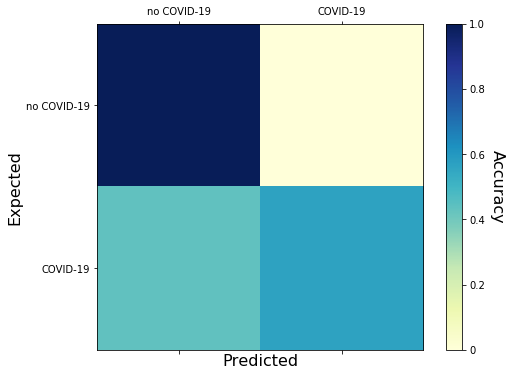

In [7]:
cm = confusion_matrix(Y_test, preds)
print("Accuracy:", accuracy_score(Y_test, preds))
print('{} of {} no COVID-19'.format(cm[0,0], np.sum(Y_test == 0)))
print('{} of {} COVID-19'.format(cm[1,1], np.sum(Y_test == 1)))
print(cm)
cm = normalize(cm, 'l1')
labels = ['no COVID-19', 'COVID-19']
fig3, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(cm, cmap='YlGnBu', vmin=0, vmax=1)
cbar = fig3.colorbar(cax)
cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
cbar.set_ticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1.0'])
cbar.ax.set_ylabel('Accuracy', rotation=270, labelpad=20, fontsize=16)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
ax.set_ylabel('Expected', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
fig3.savefig('Figures/cm_RFclassifier_v4.png', dpi=200)

## Regressor:

In [19]:
predsr = np.loadtxt('preds_RFr_v4.txt', delimiter=',')
nocovid = predsr[np.where(Y_test == 0)]
covid = predsr[np.where(Y_test == 1)]
print("\n\n---------- Predictions ----------\n")

IndexError: index 2195 is out of bounds for axis 1 with size 2195

In [ ]:
TP_050 = np.count_nonzero(np.where((Y_test==1) & (predsr>0.50)))
FN_050 = np.count_nonzero(np.where((Y_test==1) & (predsr<0.50)))
FP_050 = np.count_nonzero(np.where((Y_test==0) & (predsr>0.50)))
TN_050 = np.count_nonzero(np.where((Y_test==0) & (predsr<0.50)))
cm = np.array([[TP_050, TN_050],[FN_050, FP_050]])
print('{} of {} no COVID-19'.format(cm[0,0], np.sum(Y_test == 0)))
print('{} of {} COVID-19'.format(cm[1,1], np.sum(Y_test == 1)))
cm = normalize(cm, 'l1')
labels = ['no COVID-19', 'COVID-19']
fig1, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(cm, cmap='YlGnBu', vmin=0, vmax=1)
cbar = fig1.colorbar(cax)
cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
cbar.set_ticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1.0'])
cbar.ax.set_ylabel('Accuracy', rotation=270, labelpad=20, fontsize=16)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
ax.set_ylabel('Expected', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
fig1.savefig('Figures/cm_RFregressor_v4.png', dpi=200)

In [ ]:
fig2, ax = plt.subplots(figsize=(8,6))
ax.hist(nocovid, 50, histtype='step', lw=2, color='darkorange', label='No COVID')
ax.hist(covid, 50, histtype='step', lw=2, color='darkblue', label='COVID')
plt.grid()
ax.set_ylabel('Number of events /0.01', fontsize=16)
ax.set_xlabel('Score', fontsize=16)
plt.legend( loc='upper right', fontsize=14)
plt.yscale("log")
fig2.savefig('Figures/histogram_RFregressor_v4.png', dpi=200)